In [1]:
import os

In [2]:
import torch, torchvision
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
from COCOFaceMaskData import FaceMaskData

In [4]:
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

In [5]:
assert torch.cuda.is_available()

In [6]:
assert torch.__version__.startswith("1.9")

In [7]:
from detectron2.utils.logger import setup_logger
setup_logger()

<Logger detectron2 (DEBUG)>

In [8]:
imgs_path = './images'
msks_path = './annotation.csv'

# generate the data
faceMasksData = FaceMaskData(imgs_path, msks_path)
train_recs, valid_recs = faceMasksData.load_data()

In [9]:
phases = { 'train', 'valid' }
records = {
    'train':    train_recs,
    'valid':    valid_recs
}
metadata_rec = dict()
dataset_dicts = dict()

for p in phases:
    DatasetCatalog.register('masks_{}_dataset'.format(p), lambda: records[p] )
    MetadataCatalog.get('masks_{}_dataset'.format(p)).set(thing_classes=faceMasksData.classes)
    metadata_rec[p] = MetadataCatalog.get('masks_{}_dataset'.format(p))
    dataset_dicts[p] = DatasetCatalog.get('masks_{}_dataset'.format(p))


print('Training contains {} samples which is {:g}% of the data'.format(len(dataset_dicts['train']), len(dataset_dicts['train']) * 100 / (len(dataset_dicts['train']) + len(dataset_dicts['valid']))))
print('Validation contains {} samples which is {:g}% of the data'.format(len(dataset_dicts['valid']), len(dataset_dicts['valid']) * 100 / (len(dataset_dicts['train']) + len(dataset_dicts['valid']))))

print(dataset_dicts['train'][1])

Training contains 682 samples which is 79.9531% of the data
Validation contains 171 samples which is 20.0469% of the data
{'file_name': '/home/linuxgpu/anaconda3/envs/lab_1/files/./images/maksssksksss403.png', 'image_id': 'a93de0ae-2e67-11ec-aed6-005056a42007', 'width': 301, 'height': 400, 'annotations': [{'iscrowd': 0, 'bbox': [96, 226, 199, 350], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}]}


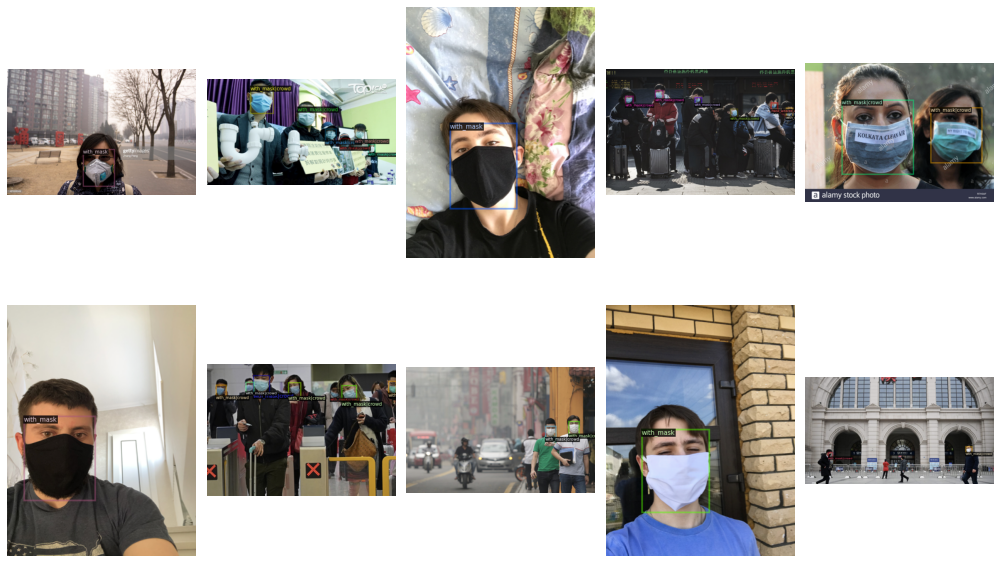

In [10]:
rows = 2
cols = 5
fig, ax = plt.subplots(rows, cols, figsize = (14, 10))

for i, d in enumerate(np.random.choice(dataset_dicts['train'], rows*cols)):
    rid, cid = i // cols, i % cols
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata_rec['train'])
    vis = visualizer.draw_dataset_dict(d)
    ax[rid, cid].imshow(cv2.cvtColor(vis.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    ax[rid, cid].axis('off')
plt.tight_layout()
plt.show()

In [11]:
%load_ext tensorboard
%tensorboard --logdir output

In [15]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ('masks_train_dataset',)
cfg.DATASETS.TEST = ('masks_valid_dataset')
cfg.DATALOADER.NUM_WORKERS = 4
cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = False
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64

cfg.TEST.EVAL_PERIOD = 500

In [16]:
class CocoTrainer(DefaultTrainer):
  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):
    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"
    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [17]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[10/16 13:00:52 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[10/16 13:00:52 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[10/16 13:00:52 d2.data.build]: Using training sampler TrainingSampler
[10/16 13:00:52 d2.data.common]: Serializing 682 elements to byte tensors and concatenating them all ...
[10/16 13:00:52 d2.data.common]: Serialized dataset takes 0.27 MiB
WARNING [10/16 13:00:52 d2.solver.build]: SOLVER.STEPS contains values larger than SOLVER.MAX_ITER. These values will be ignored.


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, 

[10/16 13:00:52 d2.engine.train_loop]: Starting training from iteration 0
[10/16 13:01:12 d2.utils.events]:  eta: 0:15:33  iter: 19  total_loss: 1.377  loss_cls: 1.007  loss_box_reg: 0.05334  loss_rpn_cls: 0.02754  loss_rpn_loc: 0.001804  time: 0.9528  data_time: 0.0226  lr: 0.00039962  max_mem: 7401M
[10/16 13:01:32 d2.utils.events]:  eta: 0:15:49  iter: 39  total_loss: 0.2973  loss_cls: 0.1389  loss_box_reg: 0.137  loss_rpn_cls: 0.01962  loss_rpn_loc: 0.001961  time: 0.9822  data_time: 0.0113  lr: 0.00079922  max_mem: 7546M
[10/16 13:01:51 d2.utils.events]:  eta: 0:15:29  iter: 59  total_loss: 0.4281  loss_cls: 0.1772  loss_box_reg: 0.2199  loss_rpn_cls: 0.01027  loss_rpn_loc: 0.001109  time: 0.9712  data_time: 0.0096  lr: 0.0011988  max_mem: 7546M
[10/16 13:02:10 d2.utils.events]:  eta: 0:15:04  iter: 79  total_loss: 0.4793  loss_cls: 0.1293  loss_box_reg: 0.3066  loss_rpn_cls: 0.007616  loss_rpn_loc: 0.002666  time: 0.9656  data_time: 0.0125  lr: 0.0015984  max_mem: 7546M
[10/16 13

[10/16 13:08:53 d2.engine.hooks]: Overall training speed: 497 iterations in 0:07:58 (0.9625 s / it)
[10/16 13:08:53 d2.engine.hooks]: Total training time: 0:07:58 (0:00:00 on hooks)
[10/16 13:08:53 d2.utils.events]:  eta: 0:08:07  iter: 499  total_loss: 0.2514  loss_cls: 0.08187  loss_box_reg: 0.1409  loss_rpn_cls: 0.0008968  loss_rpn_loc: 0.0008532  time: 0.9605  data_time: 0.0098  lr: 0.00999  max_mem: 7546M


KeyError: "Dataset 'm' is not registered! Available datasets are: coco_2014_train, coco_2014_val, coco_2014_minival, coco_2014_minival_100, coco_2014_valminusminival, coco_2017_train, coco_2017_val, coco_2017_test, coco_2017_test-dev, coco_2017_val_100, keypoints_coco_2014_train, keypoints_coco_2014_val, keypoints_coco_2014_minival, keypoints_coco_2014_valminusminival, keypoints_coco_2014_minival_100, keypoints_coco_2017_train, keypoints_coco_2017_val, keypoints_coco_2017_val_100, coco_2017_train_panoptic_separated, coco_2017_train_panoptic_stuffonly, coco_2017_train_panoptic, coco_2017_val_panoptic_separated, coco_2017_val_panoptic_stuffonly, coco_2017_val_panoptic, coco_2017_val_100_panoptic_separated, coco_2017_val_100_panoptic_stuffonly, coco_2017_val_100_panoptic, lvis_v1_train, lvis_v1_val, lvis_v1_test_dev, lvis_v1_test_challenge, lvis_v0.5_train, lvis_v0.5_val, lvis_v0.5_val_rand_100, lvis_v0.5_test, lvis_v0.5_train_cocofied, lvis_v0.5_val_cocofied, cityscapes_fine_instance_seg_train, cityscapes_fine_sem_seg_train, cityscapes_fine_instance_seg_val, cityscapes_fine_sem_seg_val, cityscapes_fine_instance_seg_test, cityscapes_fine_sem_seg_test, cityscapes_fine_panoptic_train, cityscapes_fine_panoptic_val, voc_2007_trainval, voc_2007_train, voc_2007_val, voc_2007_test, voc_2012_trainval, voc_2012_train, voc_2012_val, ade20k_sem_seg_train, ade20k_sem_seg_val, masks_valid_dataset, masks_train_dataset"

In [18]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, 'model_final.pth')
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)

In [19]:
evaluator = COCOEvaluator('masks_valid_dataset', cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, 'masks_valid_dataset')
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [10/16 13:13:09 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[10/16 13:13:09 d2.evaluation.coco_evaluation]: 'masks_valid_dataset' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
WARNING [10/16 13:13:09 d2.data.datasets.coco]: Using previously cached COCO format annotations at './output/masks_valid_dataset_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[10/16 13:13:09 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[10/16 13:13:09 d2.data.common]: Serializing 682 elements to byte tensors and concatenating them all ...
[10/16 13:13:09 d2.data.common]: Serialized dataset takes 0.27 MiB
[10/16 13:13:09 d2.evaluation.evaluator]: Start inference on 682 batches
[10/16 13:13:11 d2.eva

AssertionError: Results do not correspond to current coco set

In [ ]:
rows = 2
cols = 5
fig, ax = plt.subplots(rows, cols, figsize = (14, 10))

for i, d in enumerate(np.random.choice(dataset_dicts['valid'], rows*cols)):
    rid, cid = i // cols, i % cols
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    
    v = Visualizer(img[:, :, ::-1], metadata=metadata_rec['valid'], scale=1., instance_mode=ColorMode.IMAGE)
    v = v.draw_instance_predictions(outputs['instances'].to('cpu'))
    result = v.get_image()[:, :, ::-1]
    ax[rid, cid].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    ax[rid, cid].axis('off')
plt.tight_layout()
plt.show()